In [1]:
import os, sys, re, pickle
import numpy as np
import pandas as pd

In [2]:
sys.path.insert(0, '/home/jgutman/mvesc/ETL')
sys.path.insert(0, '/home/jgutman/mvesc/Models_Results')

In [3]:
from mvesc_utility_functions import *

In [4]:
import itertools
from my_timer import Timer

In [5]:
from save_reports import *

In [6]:
#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "all"

In [7]:
from sklearn.metrics import precision_score, recall_score
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
model_list = ["'RF'", "'logit'"]
batch_date = '08_17_2016'
table_name = '_'.join(['best_models', batch_date])
outcome = 'definite_plus_ogt'

with postgres_pgconnection_generator() as connection:
    with connection.cursor() as cursor:
        temp_explore_results = """
        drop table if exists {table};
        create temporary table {table} as
            select model_name, filename, prediction_grade, label, 
            val_set, val_recall_5_15, test_set, test_recall_5_15 
            from model.reports
            where filename in 
                (select distinct on (prediction_grade, model_name)
                filename from model.reports
                where filename like '{batch_date}%'
                and cv_criterion like 'custom_recall%'
                and model_name in ({model_list})
                and label like '{outcome}'
                order by prediction_grade, model_name, cv_score desc)
            and cv_criterion like 'custom_recall%'
            order by model_name, prediction_grade;
        """.format(table = table_name, batch_date=batch_date,
                      model_list = ', '.join(model_list), outcome = outcome)
        cursor.execute(temp_explore_results)
        
        get_val_test_years = """
        select prediction_grade, val_set, test_set
            from {table} where model_name = {first_model}
        """.format(table = table_name, first_model = model_list[0])
        cursor.execute(get_val_test_years)
        val_test_years = cursor.fetchall()
        
        store_outcome_counts = pd.DataFrame(index = [year[0] for year in val_test_years], 
                columns = ['val_set', 'val_neg', 'val_pos', 'val_pct_pos',
                           'test_set', 'test_neg', 'test_pos', 'test_pct_pos'])
        for grade, val, test in val_test_years:
            get_counts = """ select count({outcome})
                from model.outcome where cohort_{grade}th in ({val}, {test})
                and {outcome} is not null
                group by (cohort_{grade}th, {outcome})
                order by (cohort_{grade}th, {outcome});
            """.format(outcome = outcome, grade = grade, val = val, test = test)
            cursor.execute(get_counts)
            results = [i[0] for i in cursor.fetchall()]
            store_outcome_counts.loc[grade] = [val, results[0], results[1], 
                results[1]/(results[0]+results[1]), test, results[2], results[3],
                results[3]/(results[2]+results[3])]

In [9]:
store_outcome_counts

,val_set,val_neg,val_pos,val_pct_pos,test_set,test_neg,test_pos,test_pct_pos
6,2008,875,107,0.108961,2009,930,88,0.086444
7,2009,891,110,0.10989,2010,1036,117,0.101474
8,2010,1113,141,0.11244,2011,1801,226,0.111495
9,2011,1881,276,0.127955,2012,2037,281,0.121225
10,2012,1838,252,0.120574,2013,2034,252,0.110236


In [10]:
def color_gt(val,x=.5,c='blue',neg=True):
    """
    Colors values greater than x blue (or other provided color)
    
    :param float x: lower bound on colored values
    :param str c: color
    :param bool neg: if true, color negative values red
    :returns: css string to color values in dataframe
    :rtype: str
    """
    
    if val > x:
        color = c 
    elif val < 0:
        color = 'red' 
    else: color = 'black'
    return 'color: %s' % color

def table_exists(cursor, table, schema='clean'):
    """
    Checks to see if a table exists in the database
    
    :param pg.cursor cursor: 
    :param str table:
    :param str schema:
    :rtype: bool
    """
    cursor.execute("""                                                   
            select count(*) from information_schema.tables                       
            where table_schema = %s and table_name = %s
            """, [schema, table])
    return cursor.fetchall()[0][0]

In [148]:
def plot_metric(y_scores, y_true, ax, gr, max_k, metric='recall'):
    if type(y_scores) != pd.core.series.Series:
        try:
            y_scores = pd.Series(y_scores)
        except:
            print('y_scores must be a Series or a DataFrame')
            sys.exit(1)
            
    n = int(len(y_scores)*(max_k))
    curve = np.zeros([n,1])
    ranks = y_scores.rank(method='first', ascending=False)
    if metric=='recall':
        scorer = recall_score
    elif metric=='precision':
        scorer = precision_score
    else:
        print('metric not found')
    for i in range(n):
        pred = pd.Series([1 if r <= i+1 else 0 for r in ranks])
        curve[i] = scorer(y_true, pred)
    
    percents = (np.arange(n)+1)/len(y_scores)
    ax.plot(percents, curve, label = 'at grade {}'.format(gr))

In [12]:
with postgres_pgconnection_generator() as connection:
    with connection.cursor() as cursor:
        select_models = """
        select * from model.reports where filename in 
        (select distinct on (prediction_grade, model_name) 
            filename from model.reports
            where filename like '08_17_2016%'
            and cv_criterion like 'custom_recall%'
            order by prediction_grade, model_name, cv_score desc)
        and cv_criterion like 'custom_recall%'
        order by model_name, prediction_grade;
        """
        cursor.execute(select_models)
        results_raw = cursor.fetchall()
        cols = [desc[0] for desc in cursor.description]
results = pd.DataFrame(results_raw, columns=cols)
print(results.filename)

0       08_17_2016_grade_6_param_set_8_logit_jg_97
1     08_17_2016_grade_7_param_set_17_logit_jg_100
2     08_17_2016_grade_8_param_set_16_logit_jg_111
3     08_17_2016_grade_9_param_set_22_logit_jg_127
4    08_17_2016_grade_10_param_set_22_logit_jg_123
5         08_17_2016_grade_6_param_set_8_RF_jg_136
6        08_17_2016_grade_7_param_set_17_RF_jg_138
7        08_17_2016_grade_8_param_set_16_RF_jg_161
8        08_17_2016_grade_9_param_set_22_RF_jg_171
9       08_17_2016_grade_10_param_set_16_RF_jg_139
Name: filename, dtype: object


In [13]:
scores_list = dict()
scores = dict()
y_list = dict()
y = dict()
grade_range = pd.unique(results.prediction_grade)

with Timer('reading_in_predictions') as t:
    with postgres_pgconnection_generator() as connection:
        with connection.cursor() as cursor:
            for (filename, model, gr) in \
                    zip(results.filename, results.model_name, results.prediction_grade):
                cursor.execute("""
                select student_lookup, true_label, predicted_score, split 
                from model.predictions_new
                where filename = '{}' 
                and split != 'train';""".format(filename))
                temp = pd.DataFrame.from_records(cursor.fetchall(), 
                    columns = [i[0] for i in cursor.description],
                    index = 'student_lookup')
                if model not in scores_list:
                    scores_list[model] = list()
                    y_list[model] = list()
                scores_list[model].append(pd.DataFrame(temp.predicted_score))
                y_list[model].append(pd.DataFrame(temp.true_label))
                run_time = t.time_check()
                print('model {0} grade {1}: time {2}'.format(model, gr, run_time))

model logit grade 6: time 0.7296080589294434
model logit grade 7: time 1.2330594062805176
model logit grade 8: time 1.9130806922912598
model logit grade 9: time 3.479058265686035
model logit grade 10: time 4.493685245513916
model RF grade 6: time 4.808889627456665
model RF grade 7: time 5.434998273849487
model RF grade 8: time 5.968596458435059
model RF grade 9: time 7.849332094192505
model RF grade 10: time 9.999812841415405
reading_in_predictions: 1e+01 seconds elapsed


In [14]:
for model in pd.unique(results.model_name):
    for i, gr in enumerate(grade_range):
        scores_list[model][i].rename(columns = {
            'predicted_score': 'predicted_score_{0}'.format(gr)}, inplace=True)
        y_list[model][i].rename(columns = {
            'true_label': 'true_label_{0}'.format(gr)}, inplace=True)

    scores[model] = scores_list[model][0]
    y[model] = y_list[model][0]
    for df in scores_list[model][1:]:
        scores[model] = scores[model].join(df, how='inner')        
    for df in y_list[model][1:]:
        y[model] = y[model].join(df, how='inner')

In [36]:
scores_ranked = list()
for grade_model in zip(scores_list['RF'], y_list['RF']):
    scores_plus = grade_model[0].merge(grade_model[1], left_index=True, right_index=True)
    scores_ranked.append(scores_plus.sort_values(scores_plus.columns[0], ascending = False))

In [62]:
results.columns

Index(['model_name', 'filename', 'random_seed', 'label', 'cv_scheme',
       'cv_criterion', 'cv_score', 'imputation', 'scaling',
       'feature_categories', 'feature_grades', 'train_set', 'test_set',
       'parameters', 'train_acc', 'val_acc', 'test_acc', 'train_precision_3',
       'train_precision_5', 'train_precision_10', 'train_recall_3',
       'train_recall_5', 'train_recall_10', 'val_precision_3',
       'val_precision_5', 'val_precision_10', 'val_recall_3', 'val_recall_5',
       'val_recall_10', 'test_precision_3', 'test_precision_5',
       'test_precision_10', 'test_recall_3', 'test_recall_5', 'test_recall_10',
       'feature_1', 'feature_1_weight', 'feature_2', 'feature_2_weight',
       'feature_3', 'feature_3_weight', 'time', 'debug', 'timestamp',
       'prediction_grade', 'val_set', 'train_recall_5_15', 'val_recall_5_15',
       'test_recall_5_15', 'train_precision_5_15', 'val_precision_5_15',
       'test_precision_5_15', 'batch_name', 'downsample'],
      dtype='o

In [86]:
from make_predictions_for_unlabeled_students import read_in_model
from estimate_prediction_model import build_outcomes_plus_features

In [88]:
feature_misclassified_risk = dict()
for model, name in zip(scores_ranked, results.filename[results.model_name == 'RF']):
    score, label = model.columns
    students = model.loc[model[label] == 0].iloc[0:100].index
    top_features = results.loc[results.filename == name][[
            'feature_1', 'feature_2', 'feature_3']]
    top_features = top_features.iloc[0].tolist()
    clf, options = read_in_model(name, 'RF')
    features = build_outcomes_plus_features(options)
    feature_misclassified_risk[name] = features.ix[students][top_features]

In [89]:
feature_misclassified_risk['08_17_2016_grade_6_param_set_8_RF_jg_136']

,socstudies_normalized_gr_5,read_normalized_gr_5,science_normalized_gr_5
student_lookup,,,
8800.0,-1.353400,-1.692590,-1.914977
543.0,-1.232067,-1.933754,-2.205447
48129.0,-2.722872,-2.985004,-1.527361
13388.0,-2.445405,-2.450536,-2.713770
12300.0,-1.691427,-1.449459,-2.232550
13706.0,-1.019732,-1.589233,-1.515581
624.0,-1.535401,-1.485877,-0.716789
43087.0,-1.691427,-2.507279,-1.774177
13391.0,-0.837731,-1.589233,-1.769742


In [16]:
scores['logit'].head()

,predicted_score_6,predicted_score_7,predicted_score_8,predicted_score_9,predicted_score_10
student_lookup,,,,,
12524.0,0.517524,0.405282,0.667096,0.467770,0.521509
269.0,0.025756,0.023818,0.003944,0.003294,0.002252
286.0,0.127087,0.025698,0.013667,0.004812,0.009442
596.0,0.011886,0.011378,0.048726,0.022327,0.062994
624.0,0.548608,0.428403,0.644857,0.417857,0.531235


precision_recall for RF at 6


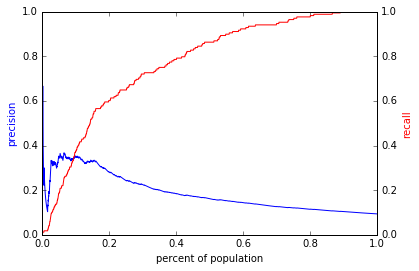

precision_recall for RF at 7


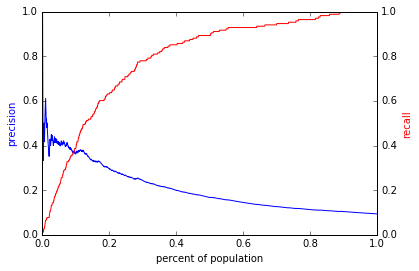

precision_recall for RF at 8


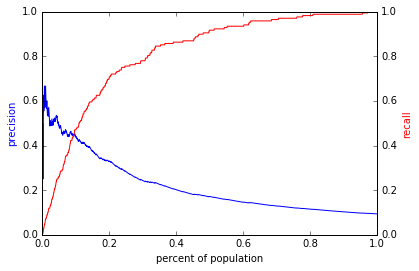

precision_recall for RF at 9


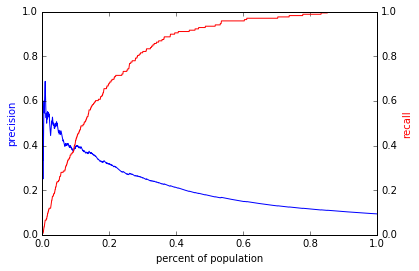

precision_recall for RF at 10


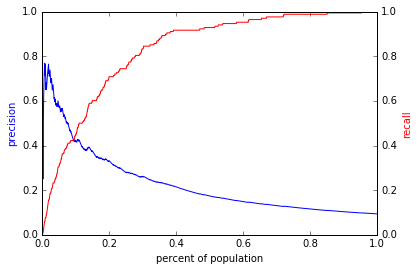

precision_recall for logit at 6


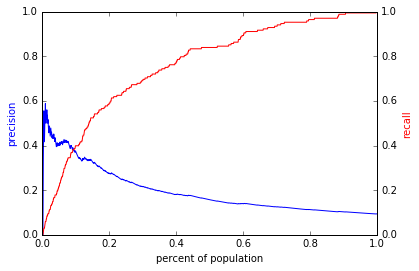

precision_recall for logit at 7


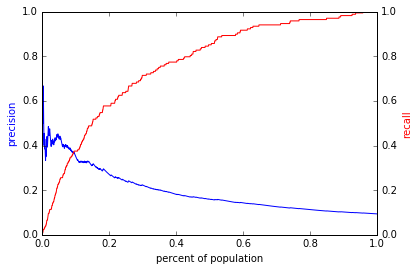

precision_recall for logit at 8


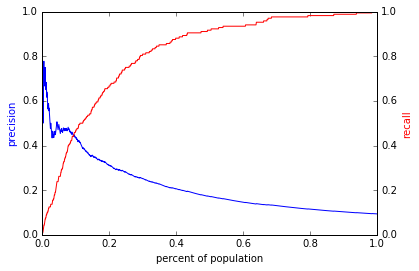

precision_recall for logit at 9


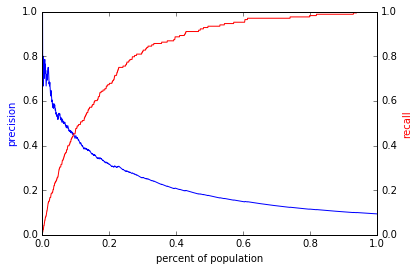

precision_recall for logit at 10


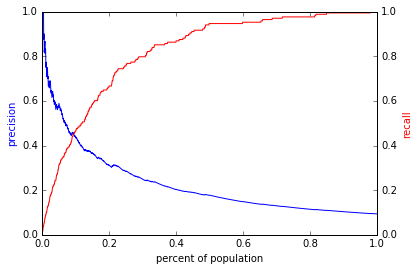

In [17]:
for model in ['RF', 'logit']:
    for grade in range(6,11):
        print('precision_recall for {model} at {grade}'.format(model=model, grade=grade))
        plot_precision_recall_n(y[model]['true_label_{}'.format(grade)], 
            scores[model]['predicted_score_{}'.format(grade)], 
            '/home/jgutman/mvesc/Reports', 'grade_{}'.format(grade), model);
        plt.show()

In [25]:
y['RF']

,true_label_6,true_label_7,true_label_8,true_label_9,true_label_10
student_lookup,,,,,
12524.0,0.0,0.0,0.0,0.0,0.0
269.0,0.0,0.0,0.0,0.0,0.0
286.0,0.0,0.0,0.0,0.0,0.0
596.0,0.0,0.0,0.0,0.0,0.0
624.0,0.0,0.0,0.0,0.0,0.0
781.0,0.0,0.0,0.0,0.0,0.0
785.0,0.0,0.0,0.0,0.0,0.0
798.0,0.0,0.0,0.0,0.0,0.0
809.0,0.0,0.0,0.0,0.0,0.0


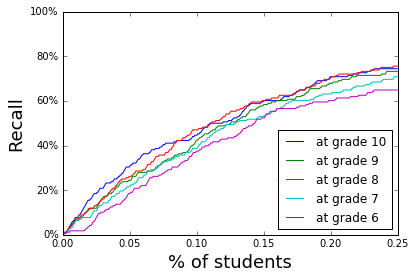

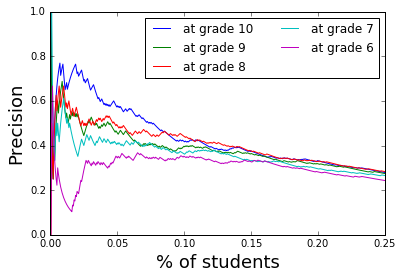

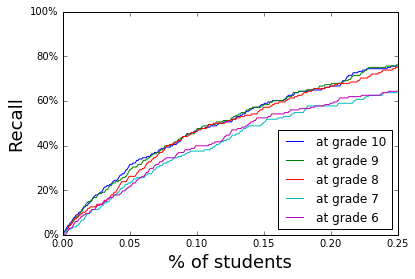

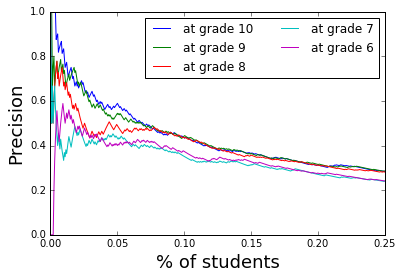

In [150]:
max_k = .25
for model in ['RF', 'logit']:
    plt.clf()
    fig1, ax1 = plt.subplots()
    fig2, ax2 = plt.subplots()

    for gr in np.arange(10,5,-1):
        plot_metric(scores[model]['predicted_score_{}'.format(gr)], 
                    y[model]['true_label_{}'.format(gr)], ax1, gr, max_k, 'recall');
        plot_metric(scores[model]['predicted_score_{}'.format(gr)], 
                    y[model]['true_label_{}'.format(gr)], ax2, gr, max_k, 'precision');

    plt.figure(fig1.number);
    ax1.legend(loc="lower right")
    ax1.set_xlabel("% of Students Targeted", fontsize=18)
    ax1.set_ylabel('Recall', fontsize=18)
    ax1.set_ylim([0,1])
    ax1.set_xlim([0,max_k])
    ax1.set_yticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])
    ax1.set_xticklabels(['0', '5', '10', '15', '20', '25'])
    plt.savefig('recall_comparison_{}_08_17_2016.png'.format(model), dpi=500)

    plt.figure(fig2.number);
    ax2.legend(loc="upper right", ncol=)
    ax2.set_xlabel("% of Students Targeted", fontsize=18)
    ax2.set_ylabel('Precision', fontsize=18)
    ax2.set_ylim([0,1])
    ax2.set_xlim([0,max_k])
    ax2.set_yticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])
    ax2.set_xticklabels(['0', '5', '10', '15', '20', '25'])
    plt.savefig('precision_comparison_{}_08_17_2016.png'.format(model), dpi=500)
    plt.show()

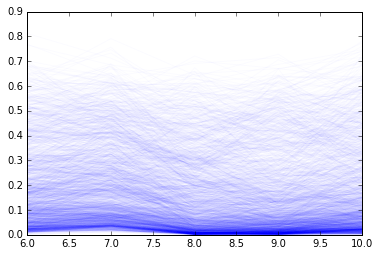

In [20]:
# risk scores over time all students
plt.clf()
fig1, ax1 = plt.subplots();
ax1.plot(range(6,11), scores['RF'].as_matrix().transpose(), alpha=0.015, color = 'b');
plt.show()

In [23]:
scores['logit'].rank().head()

,predicted_score_6,predicted_score_7,predicted_score_8,predicted_score_9,predicted_score_10
student_lookup,,,,,
12524.0,1759.0,1691.0,1774.0,1749.0,1776.0
269.0,215.0,245.0,216.5,22.5,266.0
286.0,749.0,698.0,89.5,141.0,685.0
596.0,320.0,350.0,1031.0,456.0,1233.0
624.0,1786.0,1758.0,1763.0,1631.0,1720.0


In [145]:
pred = scores['RF'].rank(ascending=False) <= round(len(scores['RF'])*.15)

In [134]:
round(len(scores['RF'])*.85)

269

In [146]:
labels_pred = pred.merge(y['RF'] == 1, left_index=True, right_index = True)

In [137]:
labels_pred.head()

,predicted_score_6,predicted_score_7,predicted_score_8,predicted_score_9,predicted_score_10,true_label_6,true_label_7,true_label_8,true_label_9,true_label_10
student_lookup,,,,,,,,,,
12524.0,True,True,True,True,True,False,False,False,False,False
269.0,False,False,False,False,False,False,False,False,False,False
286.0,False,False,False,False,False,False,False,False,False,False
596.0,False,False,False,False,False,False,False,False,False,False
624.0,True,True,True,True,True,False,False,False,False,False


In [147]:
for gr in range(6, 11):
    pred = labels_pred['predicted_score_{}'.format(gr)]
    true = labels_pred['true_label_{}'.format(gr)]
    tp = (pred & true).sum()
    pos = true.sum()
    recall = tp/pos
    print('grade {0}: {1:.3f}'.format(gr, recall))

grade 6: 0.524
grade 7: 0.530
grade 8: 0.601
grade 9: 0.583
grade 10: 0.601


In [141]:
labels_pred.sum()

predicted_score_6     269
predicted_score_7     269
predicted_score_8     269
predicted_score_9     269
predicted_score_10    269
true_label_6          168
true_label_7          168
true_label_8          168
true_label_9          168
true_label_10         168
dtype: int64

In [124]:
labels_pred.predicted_score_6 & labels_pred.true_label_6

student_lookup
12524.0    False
269.0      False
286.0      False
596.0      False
624.0      False
781.0      False
785.0      False
798.0      False
809.0      False
811.0      False
812.0      False
814.0      False
815.0      False
816.0      False
817.0      False
819.0      False
820.0      False
821.0      False
823.0      False
825.0      False
828.0      False
834.0      False
836.0      False
847.0      False
861.0      False
862.0      False
863.0      False
864.0      False
866.0      False
867.0      False
           ...  
50146.0    False
50165.0    False
50206.0    False
50234.0    False
50242.0    False
50251.0    False
50276.0    False
50292.0    False
50307.0    False
50309.0    False
50342.0    False
50415.0    False
50449.0    False
50454.0    False
50455.0    False
50477.0    False
50510.0    False
50514.0    False
50581.0    False
50600.0    False
50624.0    False
50706.0    False
51047.0    False
51284.0    False
51569.0    False
51671.0    False
52556.0    False

In [143]:
168/len(labels_pred)

0.09369771332961517

In [144]:
results.filename

0       08_17_2016_grade_6_param_set_8_logit_jg_97
1     08_17_2016_grade_7_param_set_17_logit_jg_100
2     08_17_2016_grade_8_param_set_16_logit_jg_111
3     08_17_2016_grade_9_param_set_22_logit_jg_127
4    08_17_2016_grade_10_param_set_22_logit_jg_123
5         08_17_2016_grade_6_param_set_8_RF_jg_136
6        08_17_2016_grade_7_param_set_17_RF_jg_138
7        08_17_2016_grade_8_param_set_16_RF_jg_161
8        08_17_2016_grade_9_param_set_22_RF_jg_171
9       08_17_2016_grade_10_param_set_16_RF_jg_139
Name: filename, dtype: object